In [11]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import cm
import re

In [2]:
## I'm going to try out years 981-985 in the model and see the differences between these years and years 711-715
## If there's a significant difference then I think evaluating all the years together might be useful? 

rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir_temp = 'ocean_monthly_z/ts/monthly/5yr/'
filename_temp = 'ocean_monthly_z.071101-071512.thetao.nc'



datadir_phyto = 'ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/'
filename_phyto = 'ocean_cobalt_omip_tracers_month_z.071101-071512.phyc.nc'


temp = xr.open_dataset(rootdir+datadir_temp+filename_temp)
phyto = xr.open_dataset(rootdir+datadir_phyto+filename_phyto)

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [3]:
ds = xr.merge([temp, phyto])

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [4]:
filename_volume = 'ocean_cobalt_omip_tracers_month_z.071101-071512.volcello.nc'
volume = xr.open_dataset(rootdir+datadir_phyto+filename_volume)

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [5]:
df = xr.merge([ds, volume])

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [6]:
pV = df.volcello*df.phyc
pV.name = 'pV'
df = xr.merge([df,pV])

In [7]:
df = df.set_coords('thetao')
theta_bins = np.arange(-2,30,2) 

In [10]:
## Dummy of data array that the lad Graeme made

pV_in_theta = df.pV.isel(time=0,yh=range(0,576),z_l = 0).groupby_bins('thetao',theta_bins)
p_vmean = pV_in_theta.sum(xr.ALL_DIMS)
p_vmean.values

array([2.4787871e+11, 3.0966317e+11, 2.0922397e+11, 1.7597178e+11,
       1.7413272e+11, 1.7746148e+11, 1.8660701e+11, 1.9054259e+11,
       2.1742428e+11, 1.9266558e+11, 1.3965995e+11, 1.3830695e+11,
       2.0044613e+11, 3.9632903e+11, 3.3385329e+11], dtype=float32)

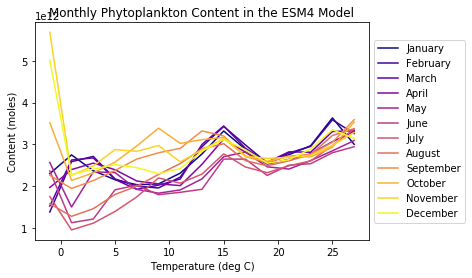

In [26]:
## WOO JESUS, THIS WAS SO ANNOYING TO FIGURE OUT. 
## Anyway, here's what the amount of moles of phytoplankton look like at different temperatures in the ocean! 

labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
colors = cm.get_cmap('plasma',12).colors 

for t in range(12):
    pV_in_theta = df.pV.isel(time=t,yh=range(0,576)).groupby_bins('thetao',theta_bins)
 
    p_vmean = pV_in_theta.sum(xr.ALL_DIMS)
       

    p_vmean.plot(label=labels[t], color=colors[t,:])
    
plt.title('Monthly Phytoplankton Content in the ESM4 Model')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Content (moles)')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 


In [ ]:
## Okie dokie so the graph above only shows monthly phytoplankton content over the course of a year
## Let's take the average of each month in the five year period and see how it looks!
## We're going to try out Graeme's new method!

datadir_temp_av = 'ocean_monthly_z/av/monthly_5yr/'
filename_temp_av = re.compile('ocean_monthly_z.0711-0715....nc') 

p_vmean_all = np.empty((12,16))

for t in range(12):
    


In [33]:
## Alrighty let's check out phytoplankton content (aka moles) over seasons
## Why? Well in the graph above there seems to be a lot of seasonality going on so I(read: we as in Graeme and I)..
## ..decided to break it down into a hopefully more decipherable graph
## We also thought it would be interesting to see how phytoplankton content changes over seasons instead of monthly

labels = ['December, January February', "March, April, May", "June, July, August", "September, October, November"]
colors = cm.get_cmap('viridis',12).colors 

DJF = [0,1,2]
MAM = [3,4,5]
JJA = [6,7,8]
SON = [9,10,11] 

for t in (DJF, MAM, JJA, SON):

    pV_in_theta = df.pV.isel(time=t,yh=range(0,576)).groupby_bins('thetao',theta_bins)
 
    p_vmean = pV_in_theta.sum(xr.ALL_DIMS)

    p_vmean.plot(label='labels' % t, color=colors[t,:])

plt.title('Seasonal Phytoplankton Concentrations in ESM4 Model')
plt.legend()
plt.xlabel('Temperature (deg C)')
plt.ylabel('Phytoplankton Content (moles)')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2acac8c1bd90> (for post_execute):


ValueError: Invalid RGBA argument: array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.283072, 0.130895, 0.449241, 1.      ],
       [0.262138, 0.242286, 0.520837, 1.      ]])

ValueError: Invalid RGBA argument: array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.283072, 0.130895, 0.449241, 1.      ],
       [0.262138, 0.242286, 0.520837, 1.      ]])

<Figure size 432x288 with 1 Axes>